# Lesson 3: Model Interpretability

In [68]:
# %load_ext autoreload
# %autoreload 2

# %matplotlib inline
# import matplotlib.pyplot as plt
# import math
from ggplot import *

In [1]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [2]:
import sys
import os
sys.path.insert(0, "/Users/JI/Documents/Github/fastai/old/")
# print(sys.path)
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/Users/JI/Documents/Github/fastai/courses/ml1/fastai/__init__.py'>


In [3]:
from fastai.structured import *
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import math

In [4]:
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn,nas= proc_df(df_raw,'SalePrice')

In [9]:
def split_vals(a,n): return a[:n],a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn,n_trn)
y_train, y_valid = split_vals(y_trn,n_trn)
raw_train, raw_valid = split_vals(df_raw,n_trn)
X_train.shape,y_train.shape,y_train.shape,y_valid.shape,raw_train.shape

((389125, 66), (389125,), (389125,), (12000,), (389125, 65))

In [10]:
def rmse(predicted,actual): return math.sqrt(((predicted-actual)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

### Confidence based on tree variance
- variance of the predicitons of the trees
- take stdev of the average of the predictions across each of the trees


In [11]:
set_rf_samples(50_000)

In [12]:
%time
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs
[0.2057407074244957, 0.24803395204979836, 0.9115342255719685, 0.8901322475489909]


In [13]:
%time
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [14]:
X_valid

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
389125,4364751,2300944,665,172,1.0,1999,3726.0,2,3232,1111,...,259,False,False,False,False,False,False,1284595200,False,False
389126,4364757,1265434,12042,172,1.0,1996,5809.0,2,3234,1112,...,343,False,False,False,False,False,False,1291852800,False,False
389127,4364774,2005935,9218,172,1.0,1993,0.0,-1,3238,1115,...,218,False,False,False,False,False,False,1281052800,False,False
389128,4364807,2296707,668,172,1.0,2000,1789.0,2,3242,1116,...,349,False,False,False,False,False,False,1292371200,False,False
389129,4364811,1403366,9219,172,1.0,1999,0.0,-1,3241,1116,...,161,False,False,False,False,False,False,1244592000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,1840702,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


#### predictions
- val set contains 12k rows (obsv) with 66 features
- preds takes the predictions of each of the 40 specificed trees (n_estimators)
    - 40 rows for each tree, 12k cols (each tree contains the average value of each of the 12k obs in the validation set
    

In [15]:
display(preds.shape,preds)

(40, 12000)

array([[9.2362 , 9.3455 , 9.29522, ..., 9.30352, 9.31191, 9.31191],
       [9.04274, 9.18989, 9.03787, ..., 9.30496, 9.25609, 9.25609],
       [9.03119, 9.05458, 9.3797 , ..., 9.71858, 9.0676 , 9.0676 ],
       ...,
       [9.28131, 9.10498, 9.01156, ..., 9.69705, 9.48296, 9.48296],
       [9.09199, 9.20299, 9.14414, ..., 9.20783, 9.59069, 9.59069],
       [9.16986, 9.11002, 9.24128, ..., 9.19911, 9.72702, 9.72702]])

In [16]:
display(np.mean(preds[:,0])) # the mean of all the trees, for the 1st observation
display(np.std(preds[:,0])) # the std of all the trees, for the 1st observation

9.199231037798423

0.22683973572182478

#### Parallelize the predictions operation

In [17]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 105 ms, sys: 79.6 ms, total: 185 ms
Wall time: 1.46 s


(9.199231037798423, 0.22683973572182478)

In [18]:
raw_valid 

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,2,KX1212,...,16,3,259,False,False,False,False,False,False,1284595200
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,2,KX151,...,9,3,343,False,False,False,False,False,False,1291852800
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,-1,KX41,...,6,4,218,False,False,False,False,False,False,1281052800
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,2,KX612,...,15,2,349,False,False,False,False,False,False,1292371200
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,-1,KX61,...,10,2,161,False,False,False,False,False,False,1244592000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


#### Visualize confidence intervals by columns
- looking to see which cols contain data, etc

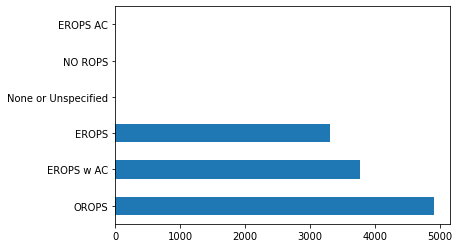

In [19]:
valid_copy = raw_valid.copy()
valid_copy['pred_std'] = np.std(preds, axis=0) # down all the trees
valid_copy['pred'] = np.mean(preds, axis=0)
valid_copy.Enclosure.value_counts().plot.barh();

##### Side note - seeing how axis=0, and axis=1 affect things
- axis=0 down rows
- axis=1 across cols

In [20]:
test = np.array([[1,1],[2,2]])
test

array([[1, 1],
       [2, 2]])

In [21]:
axis0 = np.mean(test,axis=0)
axis1 = np.mean(test,axis=1)
axis0, axis0.shape, axis1, axis1.shape

(array([1.5, 1.5]), (2,), array([1., 2.]), (2,))

#### see how Enclosure and SalePrice are related

In [22]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = valid_copy[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842070,0.275690
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574768,0.268658
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685857,0.221792


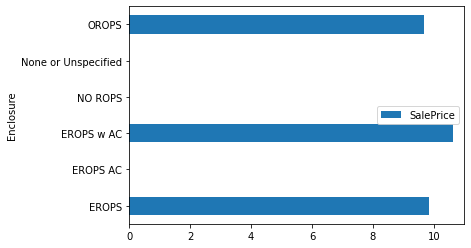

In [23]:
# enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

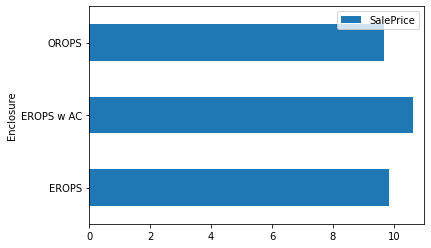

In [24]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

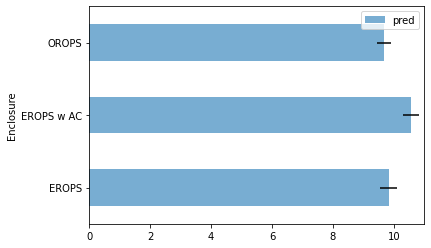

In [25]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

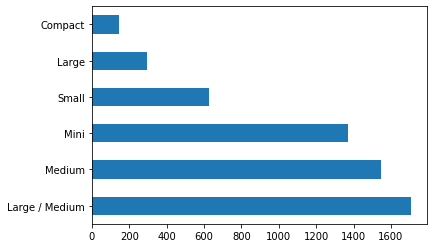

In [26]:
raw_valid.ProductSize.value_counts().plot.barh();

In [27]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = valid_copy[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.856881,0.352099
Large,10.470589,10.371027,0.370879
Large / Medium,10.691871,10.647051,0.298716
Medium,10.681511,10.613912,0.291799
Mini,9.535147,9.564968,0.251276
Small,10.324448,10.321916,0.318223


In [28]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035761
Compact           0.035721
Small             0.030830
Large / Medium    0.028056
Medium            0.027492
Mini              0.026270
dtype: float64

### Feature Importance
- which columns matter
- Data Leakage: having access to information during model development that you wouldn't have during actual decision making
- look at top10 features and try to understand more deeply
- removing reduntant cols might make predictions a little bit better, also removing colinearity (cols related to each other)
- Feature Importance: take one col and randomly shuffle so it has no relationship to the dependent variable. Then run predictions on the trained model
- look at the features that are orders of magnitude better than the others (rather than having a top 3/10 rule)
- importance means it's a lever we can change to impact our model for 

In [29]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175135
13,ProductSize,0.107725
37,Coupler_System,0.090084
14,fiProductClassDesc,0.076252
39,Hydraulics_Flow,0.052184
63,saleElapsed,0.051502
2,ModelID,0.049792
10,fiSecondaryDesc,0.046273
38,Grouser_Tracks,0.039161
19,Enclosure,0.035834


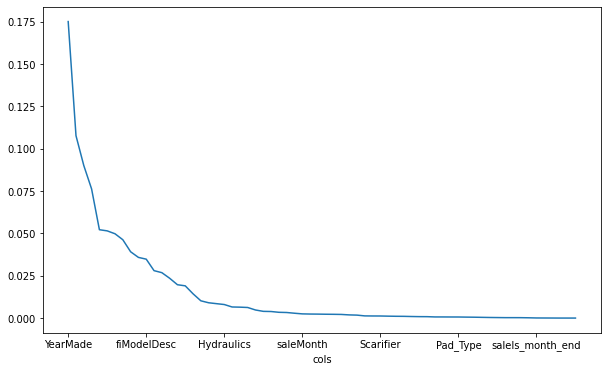

In [30]:
fi.plot('cols','imp',figsize=(10,6),legend=False)

In [31]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

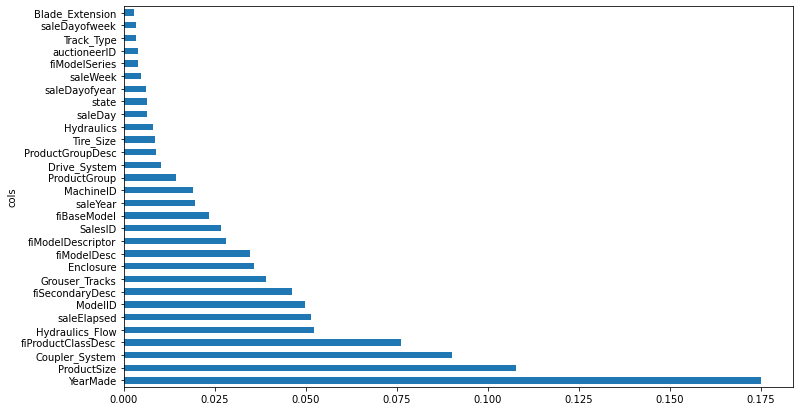

In [32]:
plot_fi(fi[:30])

In [33]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [34]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

[0.2067176494621346, 0.2463325225578763, 0.9106920866674311, 0.8916343893853246]


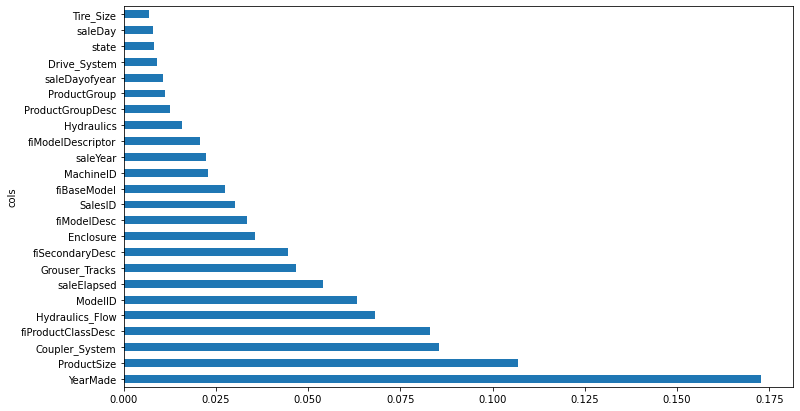

In [36]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Important hyperparameters

- **set_rf_samples** - how many samples in each tree
- depth of the tree is log_base2(sample_size) b/c binary decision
- linear relationship b/w # of leaf nodes and size of sample
- **min_samples_leaf**, each time we double we remove one layer from the tree, so with 2 leafs, would be log_base2(sample_size)-1
- **max_features**: at each split point in a tree we take the specified # of features

### Validation set diagnostic
 - Two reasons why val set might not be as good as the training set
     1. model is overfitting, either use OOB score or use a 2nd val set randomly sampled - if those get much worse, overfitting
     2. asdf
     

### one-hot encoding
- use it to see how model's feature importances change. Model may or may not improve.
- use max_n_cat to set the limilt on number of categories per feature

In [37]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2072867355353339, 0.25331761065725256, 0.910199687029718, 0.8854015509488143, 0.8924535289284353]


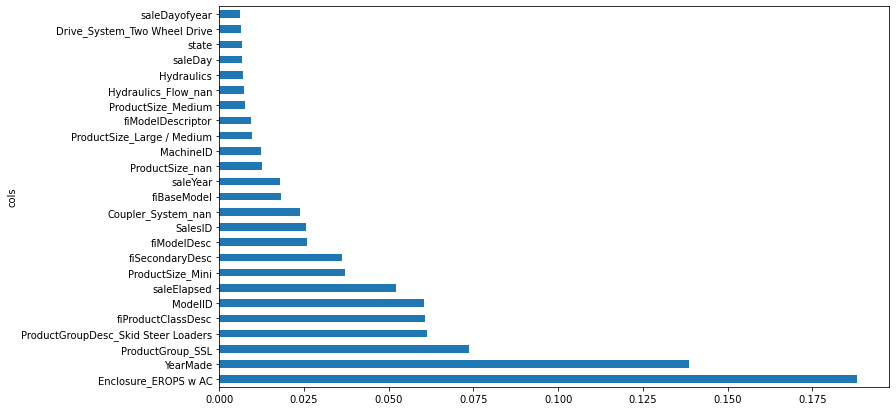

In [38]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

### Remove redundant features
- dendrogram, type of hierarchical clustering
    - find which ones are similar to each other
- correlation: similar to R^2
    - between two variables (R^2 is between a variable and its prediciton)
- problem with normal correlation: assumes linearity
- solution: rank correlation
    - replace every point by its rank
    - new plot of rank of data (order in the dataset), can look linear that way (data has to be monotonic)
    - RFs don't care about linearity, only care about order

In [39]:
from scipy.cluster import hierarchy as hc

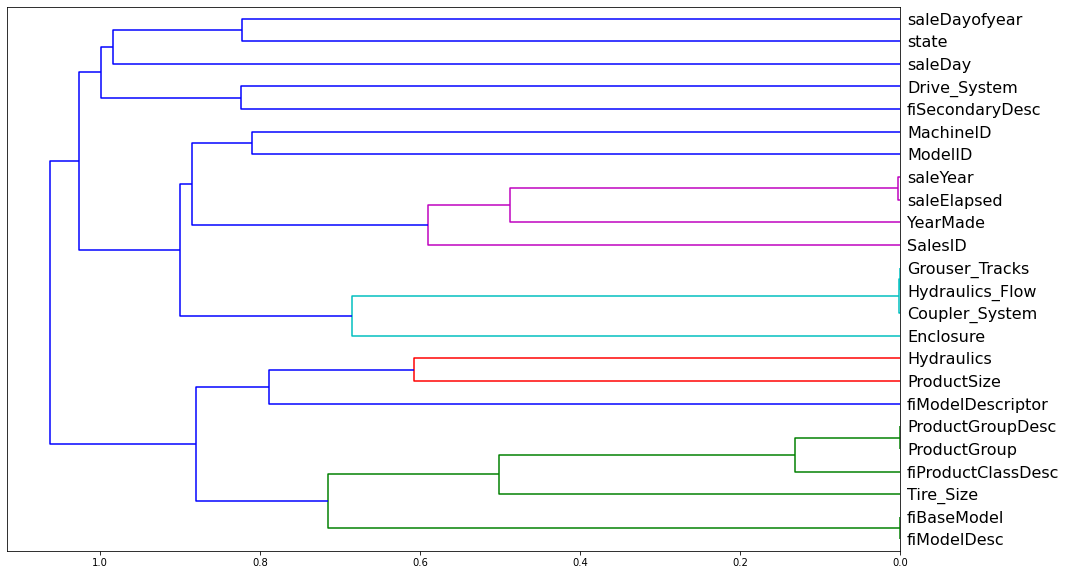

In [40]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
# correlation matrix to dendrogram, distance matrix to dendrogram
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

#### which features can we remove without making baseline oob score worse?

In [41]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [42]:
get_oob(df_keep)

0.8903712572666524

In [43]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8894647259176802
saleElapsed 0.8868501011250597
fiModelDesc 0.8891282802505289
fiBaseModel 0.8889589980695196
Grouser_Tracks 0.8898852288858016
Coupler_System 0.8901232981910808


In [44]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8889298507128032

**so dropping one from each set doesn't make much of a difference in oob_score.so drop those, and get a simpler model**

In [45]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [46]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [47]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

**test model on full dataset**

In [48]:
reset_rf_samples()

In [154]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2075916899698092, 0.2477868717518527, 0.9099352692645232, 0.8903510291786345, 0.8933261193712498]


### Partial Dependence
- find out for the features that are important, how do they relate to the dependent variable
- 

In [120]:
from pdpbox import pdp
from plotnine import *

In [121]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [155]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

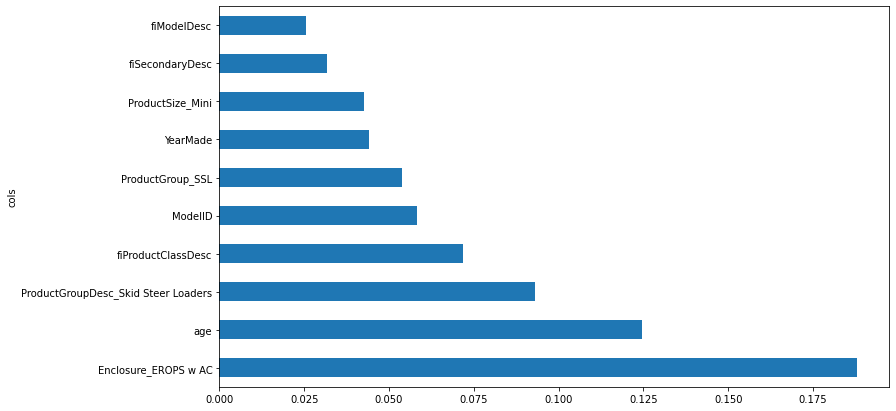

In [123]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

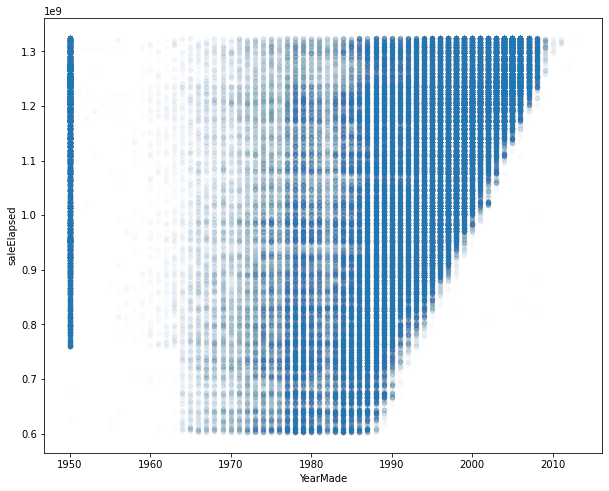

In [124]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

**interesting above, can't have year 1000 prolly records that dont have data and were filled in with some number

In [125]:
# get sample gets a random sample, better for plotting
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

**after removing year made of anything less than 1930 (for analysis), look at relationship b/w YearMade and SalePrice**

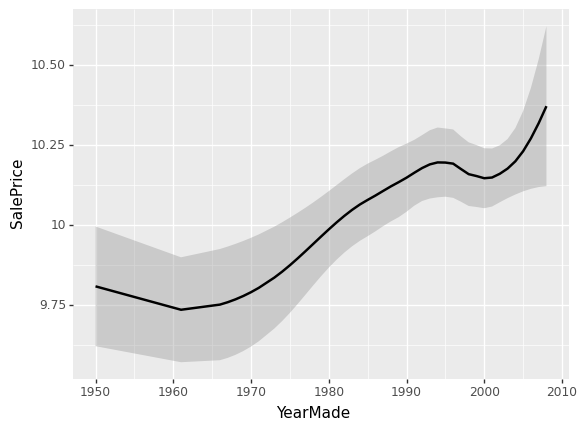

<ggplot: (356143708)>

In [126]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

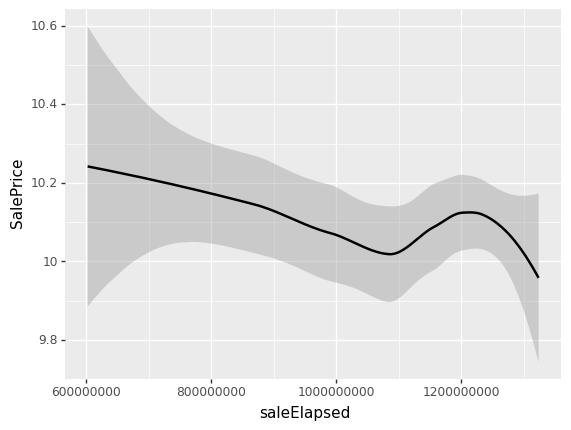

<ggplot: (-9223372036510937291)>

In [158]:
ggplot(x_all, aes('saleElapsed', 'SalePrice'))+stat_smooth(se=True, method='loess')

**why is there a dip between 1990 and 2000? would expect the price to be going up. but there could have been the same number of units sold, but lower price for some reason, etc. etc. (usually there is something else that happened)**
- what's relationship b/w SalePrice and YearMade all other things being equal?
- **solution**: partial dependence plot

In [127]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [128]:
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, 
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x149bbfb00>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x149c4ed30>})

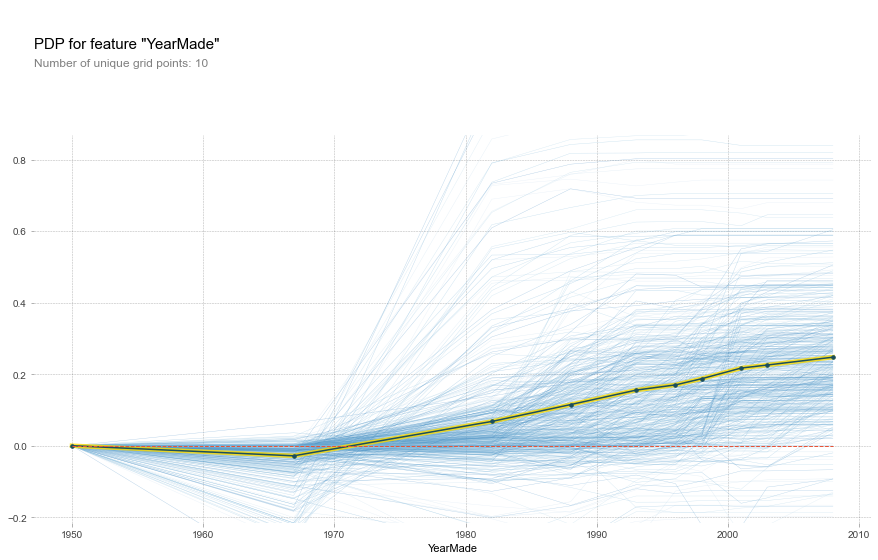

In [129]:
plot_pdp(feat_name='YearMade')

**in above plot:
- removes externalities, each line is one row of data with the year being held constant
- similar to feature importance, key difference being keeping the col all the same with constant value rather than randomly shuffling
- using already fit RF model, passing in a new year, all YearMade rows being the same
- dark line is the average, linear trend, no dip like before
- each line is one row of the data at each of the different years


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x151af35c0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x151a33a90>})

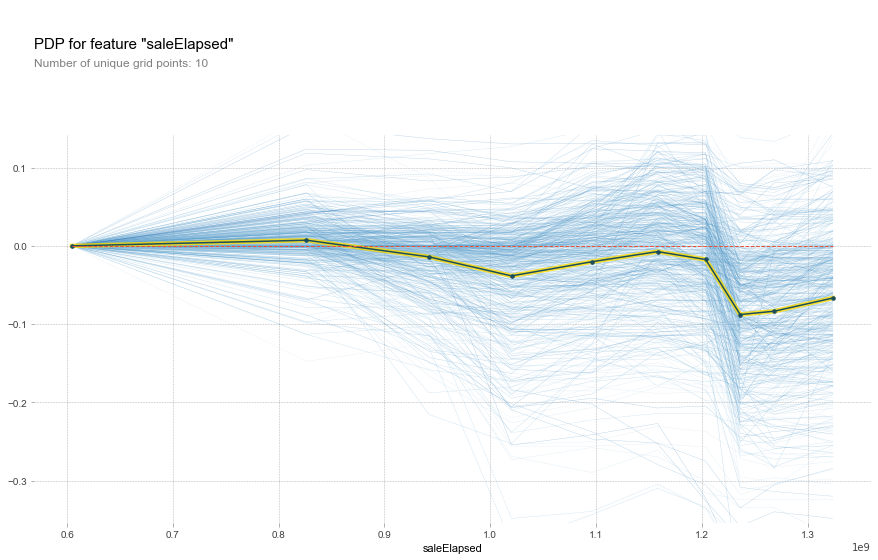

In [159]:
plot_pdp(feat_name='saleElapsed')

**can also use cluster analysis**
- same avg, but most common shapes that we see

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e0afb00>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e0b07b8>})

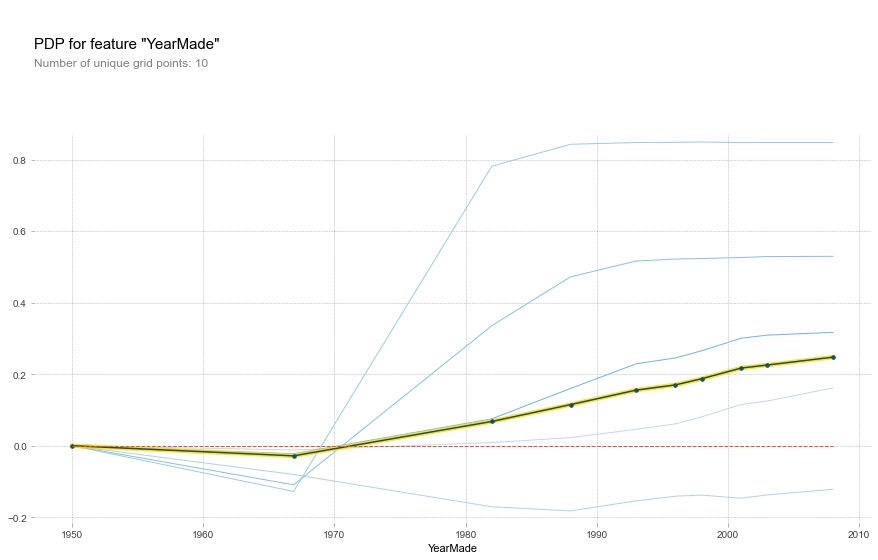

In [130]:
plot_pdp('YearMade', clusters=5)

**main take-away is that the relationship between YearMade and log(Saleprice) is linear (actual exponential)**

In [133]:
??pdp.pdp_interact_plot

Signature:
pdp.pdp_interact_plot(
    pdp_interact_out,
    feature_names,
    plot_type='contour',
    x_quantile=False,
    plot_pdp=False,
    which_classes=None,
    figsize=None,
    ncols=2,
    plot_params=None,
)
Source:   
def pdp_interact_plot(pdp_interact_out, feature_names, plot_type='contour', x_quantile=False, plot_pdp=False,
                      which_classes=None, figsize=None, ncols=2, plot_params=None):
    """PDP interact

    Parameters
    ----------

    pdp_interact_out: (list of) instance of PDPInteract
        for multi-class, it is a list
    feature_names: list
        [feature_name1, feature_name2]
    plot_type: str, optional, default='contour'
        type of the interact plot, can be 'contour' or 'grid'
    x_quantile: bool, default=False
        whether to construct x axis ticks using quantiles
    plot_pdp: bool, default=False
        whether to plot pdp for each feature
    which_classes: list, optional, default=None
        which classes to plot, onl

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x145b48a58>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x14ee3d9b0>})

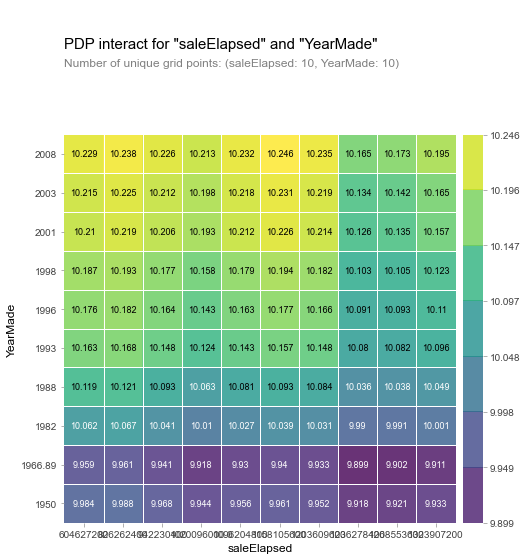

In [156]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, features=feats, model_features=x.columns)
pdp.pdp_interact_plot(p,feats, plot_type='grid')

In [145]:
??plot_pdp

Signature: plot_pdp(feat_name, clusters=None)
Docstring: <no docstring>
Source:   
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, 
                        n_cluster_centers=clusters)
File:      ~/Documents/Github/fastai/courses/ml1/<ipython-input-128-d4d69714ce5b>
Type:      function


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x141bcde48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x141c11c88>})

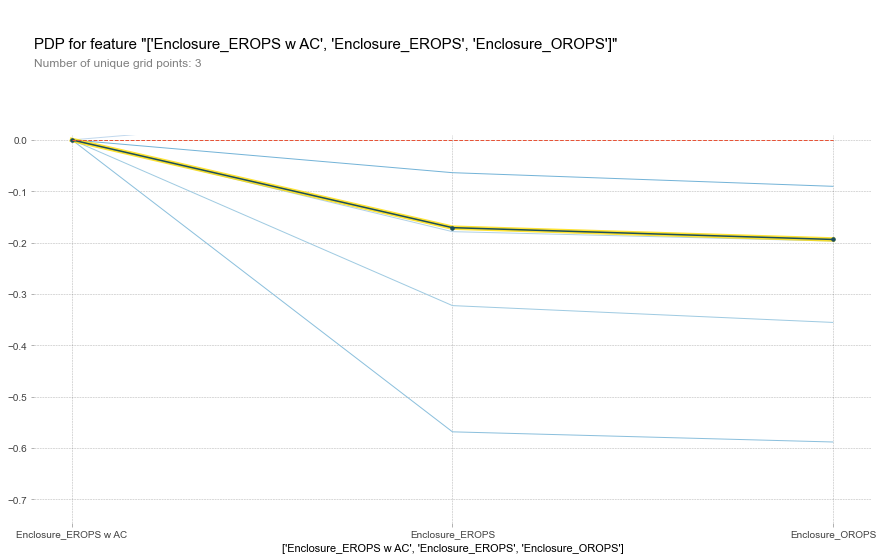

In [143]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5)

**all other things being equal, a tractor with EROPs w/ AC will sell for higher**

**below: added feature age**

In [146]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

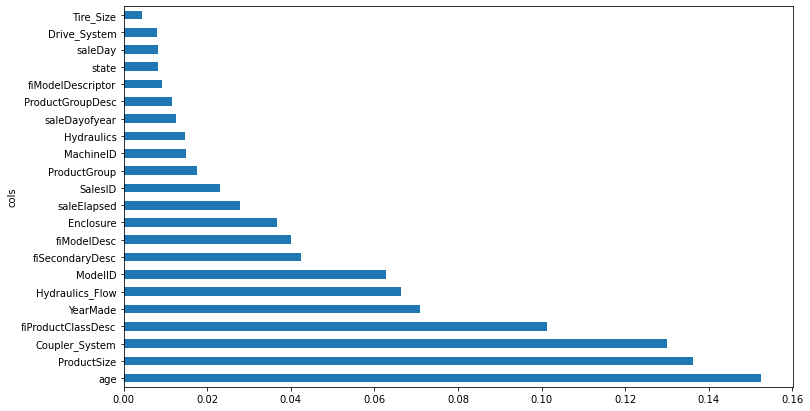

In [147]:
X_train, X_valid = splimt_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

### Tree Interpreter
- used to explain model results, when someone asks why
- why the model predicts the way it does on a certain row
- for each split in the random forest, you get an avg value for the dependent variable. Tree interpreter shows how each feature split adds/subtracts to the final value of the dependent (waterfall chart)
- allows us to take a particular row and gives back prediction, bias (avg sale price across original dataset)
- contributions: how each feature split affects final value (adds/subtracts to the final prediction)
    - summing all the contributions + bias gives prediction
- pandas sets nan to -1, fastai adds 1 to make them 0

In [160]:
from treeinterpreter import treeinterpreter as ti

In [161]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [162]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 2, 3232, 1111, 0, 63, 0, 17, 35, 0, 12, 0, 19, 29, 0,
        2010, 9, 37, 16, 3, 259, False, False, False, False, False, False, 1284595200, 11, False, False, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1]], dtype=object)

In [163]:
prediction, bias, contributions = ti.predict(m,row)

In [187]:
prediction[0], bias[0], (contributions).shape

(array([9.20014]), 10.105766428746609, (1, 171))

In [192]:
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

IndexError: index 41 is out of bounds for axis 0 with size 22

In [191]:
contributions[0].sum(),bias,contributions[0].sum()+bias,prediction[0]

(-0.9056254011744542, array([10.10577]), array([9.20014]), array([9.20014]))

### Extrapolation
- **what is the problem with RFs?**
    - for a temporal data, it can't extrapolate to future time data
- **avoid using time as a predictor is there's something else we can use**
    - build a RF to determine if something is in the val set or not

In [193]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [194]:
# RF to predict is this in the val set or not
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999875350576504

**if variable is not time dependent it shouldn't be possible to figure out if set is in validation or not, R^2 is .99 so you can predict it... somethings off...**

In [195]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.764699
5,saleElapsed,0.156145
12,MachineID,0.066530
20,saleDayofyear,0.003456
9,fiModelDesc,0.002584
6,ModelID,0.002054
2,Coupler_System,0.001053
0,YearMade,0.000964
17,Hydraulics,0.000813
7,fiSecondaryDesc,0.000562


**salesID,saleElapsed,MachineId seem to be a consecutively labeled ID***

In [196]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [197]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [198]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


**drop these ids**

In [199]:
x.drop(feats, axis=1, inplace=True)

In [200]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9785079464007479

In [201]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.225223
0,YearMade,0.186706
17,saleDayofyear,0.159150
5,ModelID,0.083149
8,fiModelDesc,0.062542
15,saleDay,0.060930
16,state,0.054568
3,fiProductClassDesc,0.033208
6,fiSecondaryDesc,0.024862
14,Hydraulics,0.021758


In [202]:
set_rf_samples(50000)

In [203]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [204]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20749300721994457, 0.2482118172375557, 0.9100208769571368, 0.8899746186847466, 0.8934804358769892]


**drop each feature one at a time and see what the score becomes**

In [205]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20871526738614318, 0.245361350819312, 0.9089576910911876, 0.8924871729203444, 0.8928824902695571]
saleElapsed
[0.21420475069946238, 0.25403761547363435, 0.9041056492483076, 0.8847491786466555, 0.8870244589489555]
MachineID
[0.20715658706259643, 0.2463829453716295, 0.9103124169108362, 0.8915900212427914, 0.8945902124119132]
age
[0.20947417572850224, 0.24788782961741646, 0.9082944106085827, 0.8902616605923723, 0.8917463648831278]
YearMade
[0.20891231920322842, 0.25225131209935897, 0.9087857005953406, 0.8863642868469284, 0.8922948473615464]
saleDayofyear
[0.20834053085589105, 0.24381730555398326, 0.9092843203014446, 0.893836059711213, 0.8933123832231297]


In [206]:
reset_rf_samples()

In [207]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13845086875848955, 0.21832051258671456, 0.9599385931461383, 0.9148789330515003, 0.9094789750053845]


In [211]:
# removing age as well
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear','age'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13855314876943658, 0.21838486295106413, 0.9598793808830878, 0.9148287464806726, 0.9107206633938716]


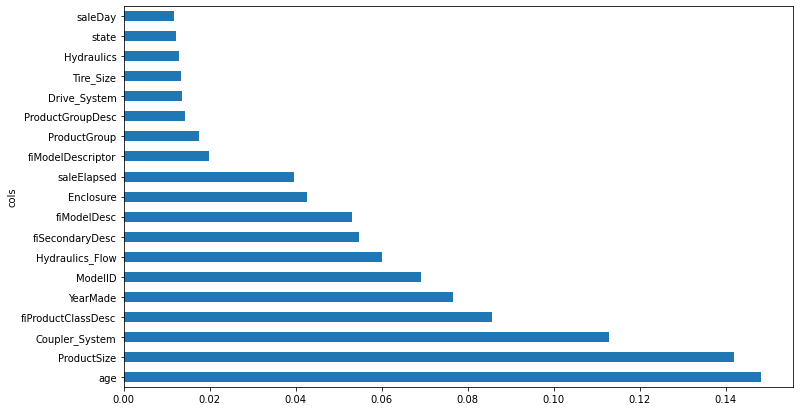

In [208]:
plot_fi(rf_feat_importance(m, X_train));

In [209]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

### Final Model!

In [210]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 5s, sys: 14.3 s, total: 6min 19s
Wall time: 2min 35s
[0.08022625727449606, 0.2109799183276237, 0.9865485875316276, 0.9205067571929707, 0.9145342088087671]


## You can apply these same steps to real world modeling problems to deliver world-class results!!

#### Quick side note on what is zip function in python
https://realpython.com/python-zip-function/

In [171]:
numbers = [1,2,3]
letters = ['a','b','c']
special = ['!','!','!']
list(zip(numbers,letters,special))

[(1, 'a', '!'), (2, 'b', '!'), (3, 'c', '!')]

In [183]:
bros = {'james':30,'tim':29}
list(zip(bros))
[print(bro,age) for bro,age in bros.items()]

james 30
tim 29


[None, None]

### Notes

#### Validation Sets

- **why can't you randomly sample for the validation set?**
    - you're trying to generalize to the future on the test set. Temporal data

- **how to choose a good validation set?**
    - 5 models on the training set, plot each model results with val set score and test set score, see if they follow a linear trend, modify validation set till you find one that is indicative of test set results. Need to have a good test set!

- **what is cross validation?**
    - having different validation sets for the same training data a certain number of times
- **what is benefit of cross validation set?**
    - useful on a smaller dataset, get to use more of the dataset
- **what is downside of cross validation?**
    - will take lot of time on a large dataset
    - random validation set might not be useful in temporal use cases

- **how big should validation set be?**
    - how accurate do you need the model to be?
    - it needs to be however big it needs to be so that your accuracy is insightful for the particular business problem
    - have at least 22 (approx starts looking normal) of each class in any of the sets
    - train 5 models and see how the validation accuracy changes

- **what is binomial dist?**
    - two choices
    - n samples, p probability
    - avg: n * p
    - std: n * p * (1-p)

#### Notes of NaNs

- missing values can tell us a lot! don't remove them, but rather learn from them!